# GPyTorch on L2P training data

Adapted from [GPyTorch](https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/Simple_MultiGPU_GP_Regression.html) tutorial.

In [12]:
import xarray as xr
import math
import torch
import gpytorch
import sys
from matplotlib import pyplot as plt
sys.path.append('../')

%load_ext autoreload
%autoreload 2

In [22]:
import sys
sys.path.append('/home/jovyan/infrastructure/notebooks')
from LBFGS import FullBatchLBFGS

## Get the data
downloaded subset of l2p viirs data from Jacob's nb in `data-preprocessing` repo

In [8]:
#from Jacob
viirs = xr.open_zarr('/home/jovyan/shared/viirs_20180701-20180707.zarr')

In [40]:
#convert lat, lon, time, sst to np arrays
lat = viirs.lat.values
lon = viirs.lon.values
time = viirs.time.values.astype('float64')
sst = viirs.sea_surface_temperature.values

In [26]:
data = torch.Tensor(loadmat('/home/jovyan/infrastructure/notebooks/protein.mat')['data'])

In [51]:
data.shape

torch.Size([45730, 10])

## Normalization and train/test splits

In [35]:
N = sst.shape[0]

In [36]:
int(0.8 * N)

1061941

In [82]:
import numpy as np

N = sst.shape[0]
# make train/val/test
n_train = int(0.8 * N)
train_x, train_y = [lat,lon,time], sst
#test_x, test_y = data[n_train:, :-1], data[n_train:, -1]

In [83]:
# normalize features
mean = np.mean(train_x)
std = np.std(train_x) #+ 1e-6 # prevent dividing by 0
train_x = (train_x - mean) / std
#test_x = (test_x - mean) / std

# normalize labels
mean, std = np.mean(train_y), np.std(train_y)
train_y = (train_y - mean) / std
#test_y = (test_y - mean) / std

# make continguous
#train_x, train_y = train_x.contiguous(), train_y.contiguous()
#test_x, test_y = test_x.contiguous(), test_y.contiguous()

output_device = torch.device('cuda:0')

#train_x, train_y = train_x.to(output_device), train_y.to(output_device)
#test_x, test_y = test_x.to(output_device), test_y.to(output_device)

In [73]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 0 GPUs.


## Define GP model and training code

In [74]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train(train_x,
          train_y,
          n_devices,
          output_device,
          checkpoint_size,
          preconditioner_size,
          n_training_iter,
):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
    model = ExactGPModel(train_x, train_y, likelihood, n_devices).to(output_device)
    model.train()
    likelihood.train()

    optimizer = FullBatchLBFGS(model.parameters(), lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
         gpytorch.settings.max_preconditioner_size(preconditioner_size):

        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            return loss

        loss = closure()
        loss.backward()

        for i in range(n_training_iter):
            options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
            loss, _, _, _, _, _, _, fail = optimizer.step(options)

            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, n_training_iter, loss.item(),
                model.covar_module.module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))

            if fail:
                print('Convergence reached!')
                break

    print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
    return model, likelihood

## Automatically determining GPU Settings

In [87]:
import gc

def find_best_gpu_setting(train_x,
                          train_y,
                          n_devices,
                          output_device,
                          preconditioner_size
):
    N = train_x[0].size

    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            _, _ = train(train_x, train_y,
                         n_devices=n_devices, output_device=output_device,
                         checkpoint_size=checkpoint_size,
                         preconditioner_size=preconditioner_size, n_training_iter=1)

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size

# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(train_x, train_y,
                                        n_devices=n_devices,
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)

Number of devices: 0 -- Kernel partition size: 0
RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx
Number of devices: 0 -- Kernel partition size: 663714
RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx
Number of devices: 0 -- Kernel partition size: 331857
RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx
Number of devices: 0 -- Kernel partition size: 165929
RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx
Number of devices: 0 -- Kernel partition size: 82965
RuntimeError: Found no NVIDIA driver on your system. Please check that you have 

## Training

In [88]:
model, likelihood = train(train_x, train_y,
                          n_devices=n_devices, output_device=output_device,
                          checkpoint_size=10000,
                          preconditioner_size=100,
                          n_training_iter=20)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Testing: Computing predictions

In [ ]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    %time latent_pred = model(test_x)

test_rmse = torch.sqrt(torch.mean(torch.pow(latent_pred.mean - test_y, 2)))
print(f"Test RMSE: {test_rmse.item()}")

# from kernel nb

In [2]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function, 
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        

def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

def plot(observed_pred, test_x=torch.linspace(0, 1, 51)):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

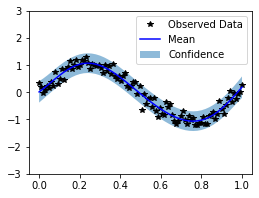

In [3]:
class SimpleSincKernel(gpytorch.kernels.Kernel):
    has_lengthscale = True
    
    # this is the kernel function
    def forward(self, x1, x2, **params):
        # apply lengthscale
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        # calculate the distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

# Use the simplest form of GP model, exact inference
class SimpleSincGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = SimpleSincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize the new model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SimpleSincGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)